In [31]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [32]:
# IMPORTS
import csv
import re
import zipfile
import pickle
import os
from io import BytesIO
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp
import seaborn as sns
plt.style.use('ggplot')
from node2vec import Node2Vec

import spacy
#python -m spacy download el_core_news_sm -- rin in cmd
nlp = spacy.load("el_core_news_sm")
nlp.max_length = 3000000

import nltk
#nltk.download("punkt")
import string
from nltk import WhitespaceTokenizer

from gensim.models import KeyedVectors, Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [33]:
# Read training data
train_domains = list()
y_train = list()
with open("train.txt", "r") as f:
    for line in f:
        l = line.split(",")
        train_domains.append(l[0])
        y_train.append(l[1][:-1])

# Read test data
test_domains = list()
with open("test.txt", "r") as f:
    for line in f:
        l = line.split(",")
        test_domains.append(l[0])

In [34]:
G = nx.read_edgelist('edgelist.txt', delimiter=' ', create_using=nx.DiGraph())

In [35]:
# Precompute probabilities and generate walks 
node2vec = Node2Vec(G, dimensions=128, workers=12, 
                    temp_folder= os.getcwd())  # Use temp_folder for big graphs

Computing transition probabilities:   0%|          | 0/65208 [00:00<?, ?it/s]

Generating walks (CPU: 2):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3):   0%|          | 0/1 [00:00<?, ?it/s]



Generating walks (CPU: 5):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 4):   0%|          | 0/1 [00:00<?, ?it/s]




Generating walks (CPU: 6):   0%|          | 0/1 [00:00<?, ?it/s]






Generating walks (CPU: 8):   0%|          | 0/1 [00:00<?, ?it/s]








Generating walks (CPU: 10):   0%|          | 0/1 [00:00<?, ?it/s]







Generating walks (CPU: 9):   0%|          | 0/1 [00:00<?, ?it/s]





Generating walks (CPU: 7):   0%|          | 0/1 [00:00<?, ?it/s]









Generating walks (CPU: 11): 0it [00:00, ?it/s]










Generating walks (CPU: 11): 0it [00:00, ?it/s]
Generating walks (CPU: 12): 0it [00:00, ?it/s]
Generating walks (CPU: 9): 100%|██████████| 1/1 [00:46<00:00, 46.67s/it]


In [46]:
#n2v_model = node2vec.fit(window=1, min_count=1, batch_words=4, seed=123)  
n2v_model_128 = node2vec.fit(window=10, min_count=1, batch_words=4, seed=123)  

In [47]:
n2v_model = n2v_model_128

In [48]:
#SAVE MODELS
filename = 'n2v_model_128.sav'
pickle.dump(n2v_model_128, open(filename, 'wb'))

#OPEN MODEL
n2v_model = pickle.load(open(filename, 'rb'))

filename = 'n2v_model_128.sav'
pickle.dump(n2v_model_32, open(filename, 'wb'))

#OPEN MODEL
n2v_model_128 = pickle.load(open(filename, 'rb'))

In [49]:
# Look for most similar nodes
n2v_model_32.wv.most_similar(train_domains[1])

[('ginis.gr', 0.8495969176292419),
 ('hydra.gr', 0.8344131112098694),
 ('pikounis.gr', 0.811144232749939),
 ('kythnos.gr', 0.8033208250999451),
 ('skiathos.gr', 0.8019258975982666),
 ('kythera.gr', 0.8007026314735413),
 ('amanita.gr', 0.7981640100479126),
 ('kalamatacvb.gr', 0.793961226940155),
 ('vrellis.gr', 0.7938706278800964),
 ('anilio-ski.gr', 0.7927257418632507)]

In [50]:
# Look for most similar nodes
n2v_model_32.wv.most_similar(train_domains[1])

[('ginis.gr', 0.8495969176292419),
 ('hydra.gr', 0.8344131112098694),
 ('pikounis.gr', 0.811144232749939),
 ('kythnos.gr', 0.8033208250999451),
 ('skiathos.gr', 0.8019258975982666),
 ('kythera.gr', 0.8007026314735413),
 ('amanita.gr', 0.7981640100479126),
 ('kalamatacvb.gr', 0.793961226940155),
 ('vrellis.gr', 0.7938706278800964),
 ('anilio-ski.gr', 0.7927257418632507)]

In [54]:
# Create the training matrix. Each row corresponds to a web host.
X_train = np.zeros((len(train_domains), 32))
for i, domain in enumerate(train_domains):
    X_train[i, :] = n2v_model_32.wv[domain]

X_test = np.zeros((len(test_domains), 32))
for i, domain in enumerate(test_domains):
    X_test[i, :] = n2v_model_32.wv[domain]

In [55]:
#Save text results
with open('X_train_graph_n2v_128', 'wb') as f:
    pickle.dump(X_train, f)
      
with open('X_test_graph_n2v_128', 'wb') as f:
    pickle.dump(X_test, f)

#### Tuning 

In [56]:
# Create text matrix
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

ValueError: Found input variables with inconsistent numbers of samples: [1258, 1006]

In [ ]:
clf = LogisticRegression(max_iter=10000)
parameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
              {'penalty':['none', 'elasticnet', 'l1', 'l2']},
              {'C':[0.001, 0.01, 0.1, 1, 10, 100]}]


grid_search = GridSearchCV(estimator = clf,  
                           param_grid = parameters,
                           scoring = 'f1_weighted',
                           cv = 5,
                           verbose=0)


grid_search.fit(X_train, y_train)
y_pred = grid_search.predict_proba(X_val)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(np.array(list(map(int, y_val))), np.argmax(y_pred, axis=1)))
confusion_matrix(np.array(list(map(int, y_val))), np.argmax(y_pred, axis=1))

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(np.array(list(map(int, y_val))), np.argmax(y_pred, axis=1)))
confusion_matrix(np.array(list(map(int, y_val))), np.argmax(y_pred, axis=1))

              precision    recall  f1-score   support

           0       0.62      0.91      0.73        64
           1       0.67      0.50      0.57        28
           2       0.50      0.30      0.37        37
           3       0.82      0.85      0.83        79
           4       0.78      0.64      0.70        11
           5       0.57      0.80      0.67         5
           6       0.45      0.38      0.42        13
           7       0.50      0.25      0.33         4
           8       0.00      0.00      0.00         5
           9       0.25      0.17      0.20         6

    accuracy                           0.67       252
   macro avg       0.52      0.48      0.48       252
weighted avg       0.64      0.67      0.64       252



array([[58,  0,  3,  0,  0,  1,  2,  0,  0,  0],
       [ 8, 14,  2,  3,  0,  0,  1,  0,  0,  0],
       [16,  3, 11,  3,  0,  0,  1,  0,  0,  3],
       [ 2,  2,  5, 67,  0,  1,  2,  0,  0,  0],
       [ 2,  0,  0,  2,  7,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  4,  0,  0,  0,  0],
       [ 4,  1,  0,  2,  0,  1,  5,  0,  0,  0],
       [ 2,  0,  0,  1,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  3,  1,  0,  0,  1,  0,  0],
       [ 2,  1,  1,  1,  0,  0,  0,  0,  0,  1]])

### Final Submission

In [23]:
# Create the training matrix. Each row corresponds to a web host.
X_train = np.zeros((len(train_domains), 32))
for i, domain in enumerate(train_domains):
    X_train[i, :] = n2v_model_32.wv[domain]

# Create text matrix

X_test = np.zeros((len(test_domains), 32))
for i, domain in enumerate(test_domains):
    X_test[i, :] = n2v_model_32.wv[domain]
    
y_train = list()
with open("train.txt", "r") as f:
    for line in f:
        l = line.split(",")
        train_domains.append(l[0])
        y_train.append(l[1][:-1])

In [24]:
# Use logistic regression to classify the webpages of the test set
clf = LogisticRegression(**grid_search.best_params_, max_iter=10000)
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)

In [24]:
# Write predictions to a file
with open('sample_submission.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = list()
    for i in range(10):
        lst.append('class_'+str(i))
    lst.insert(0, "domain_name")
    writer.writerow(lst)
    for i,test_domain in enumerate(test_domains):
        lst = y_pred[i,:].tolist()
        lst.insert(0, test_domain)
        writer.writerow(lst)

### Visualization of Graphs 

In [ ]:
import seaborn as sns

In [25]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_train)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1258 samples in 0.000s...
[t-SNE] Computed neighbors for 1258 samples in 0.035s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1258
[t-SNE] Computed conditional probabilities for sample 1258 / 1258
[t-SNE] Mean sigma: 0.363360
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.093369
[t-SNE] KL divergence after 300 iterations: 1.356420


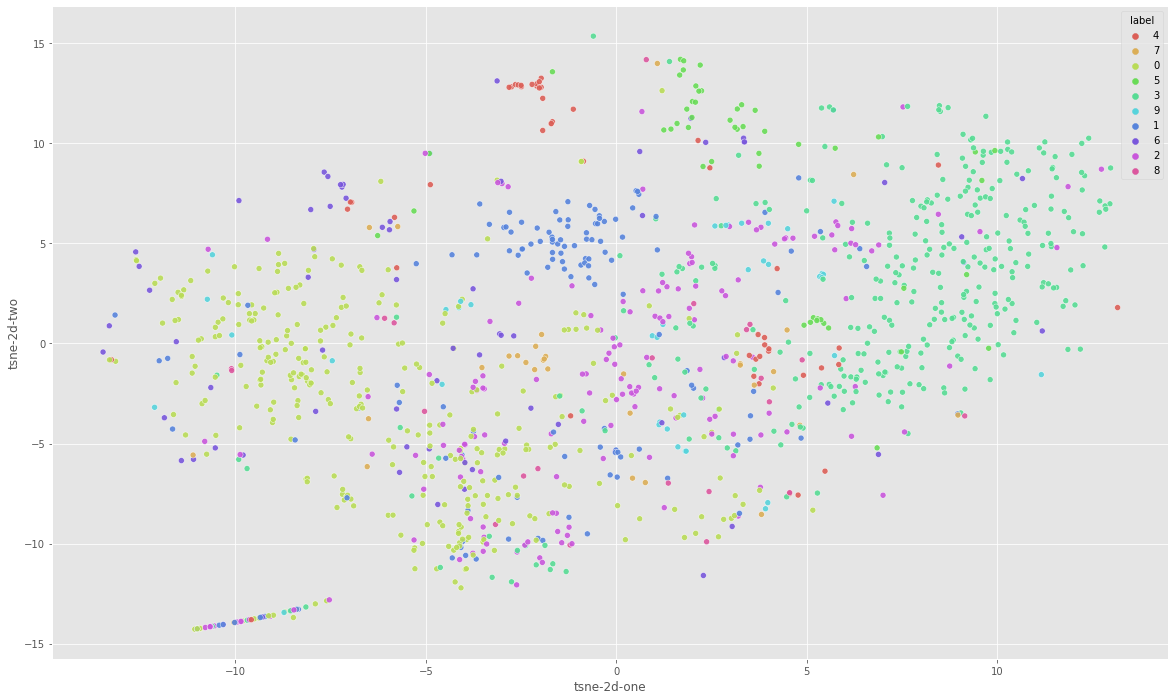

In [30]:
df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['label'] = y_train

plt.figure(figsize=(20,12));
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two", hue='label',
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.9
);